# Model experiments

In this notebook we will experiment with different models and different fitting and we will compare the results.

In [30]:
# Basic imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.stats.stattools import durbin_watson
sns.set_style("darkgrid")
from scipy import signal

from scipy.stats import normaltest
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.api as sm
import pymannkendall as mk

from pandas.plotting import autocorrelation_plot


from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.graphics.tsaplots import plot_predict

import itertools
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
path = "../../data_postprocess/data_nuevo/"
path_bruto = "../../data/"


In [2]:
def plot_zoom(model_fit, df, df_test,n, var):
    plt.figure(figsize=(16, 10))
    predictions = model_fit.predict(n,len(df_test)+n-1, dynamic=True)
    predictions.index = df_test.index
    df.iloc[-(df_test.shape[0]+1000):,:][var].plot(label='true values')
    predictions.plot(label='predicted values')
    plt.legend()



In [3]:
#We create a function because we are going to use this two cells in all the models that we train

def metrics(model_fit, df_test, df_train):
    print("TRAIN SET METRICS")
    train_forecast = model_fit.predict(start=df_train.index[0], end=df_train.index[-1])
    mae = mean_absolute_error(df_train, train_forecast)
    mape = mean_absolute_percentage_error(df_train, train_forecast)
    rmse = np.sqrt(mean_squared_error(df_train, train_forecast))

    print(f'mae: {mae}')
    print(f'mape: {mape}')
    print(f'rmse: {rmse}')

    print("TEST SET METRICS")
    test_forecast = model_fit.forecast(len(df_test))
    mae = mean_absolute_error(df_test, test_forecast)
    mape = mean_absolute_percentage_error(df_test, test_forecast)
    rmse = np.sqrt(mean_squared_error(df_test, test_forecast))

    print(f'mae: {mae}')
    print(f'mape: {mape}')
    print(f'rmse: {rmse}')


In [59]:
def metrics2(test_forecast, df_test):
    

    print("TEST SET METRICS")
    mae = mean_absolute_error(df_test, test_forecast)
    mape = mean_absolute_percentage_error(df_test, test_forecast)
    rmse = np.sqrt(mean_squared_error(df_test, test_forecast))

    print(f'mae: {mae}')
    print(f'mape: {mape}')
    print(f'rmse: {rmse}')

In [4]:
def residual_analysis(residuals, lags=40, test_lags = [1, 10], alpha=0.05, title=""):
    """
    Generate various plots and tests to analyze the residuals.

    Parameters:
        residuals (array-like): Residuals to analyze
        lags (int): Number of lags to include in the autocorrelation and partial autocorrelation plots
        alpha (float): Significance level for the Ljung-Box test

    Returns:
        None
    """

    # Create common subplot for all plots
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    fig.subplots_adjust(hspace=0.5)

    # Autocorrelation plot with confidence intervals
    sm.graphics.tsa.plot_acf(residuals, lags=lags, ax=axes[0, 0], alpha=alpha)
    axes[0, 0].set(title="Autocorrelation Plot",
                  xlabel="Lag", ylabel="Autocorrelation")

    # Partial autocorrelation plot
    sm.graphics.tsa.plot_pacf(residuals, lags=lags, ax=axes[0, 1])
    axes[0, 1].set(title="Partial Autocorrelation Plot", xlabel="Lag", ylabel="Partial Autocorrelation")

    # Q-Q plot
    sm.graphics.qqplot(residuals, line='s', ax=axes[1, 0])
    axes[1, 0].set(title="Q-Q Plot", xlabel="Theoretical Quantiles", ylabel="Sample Quantiles")

    # Histogram plot with kde line
    sns.histplot(residuals, bins=30, kde=True)
    axes[1, 1].set(title="Histogram with KDE Line", xlabel="Residuals", ylabel="Frequency")
    plt.suptitle("Residual analysis for: " + title)
    plt.show()

    # Normality test
    pvalue = normaltest(residuals)[1]
    if pvalue < alpha:
        print("The residuals do not follow a normal distribution (p-value = {:.20f}, alpha = {})".format(pvalue, alpha))
    else:
        print("The residuals follow a normal distribution (p-value = {:.20f}, alpha = {})".format(pvalue, alpha))

    # Ljung-Box test
    test_results = acorr_ljungbox(residuals, lags=test_lags, auto_lag=True)
    pvalues = test_results['lb_pvalue']
    if np.any(pvalues < alpha):
        print("The residuals are autocorrelated (some p-values < alpha = {:.10f})".format(alpha))
        print(test_results)
    else:
        print("The residuals are not autocorrelated (all p-values >= alpha = {:.10f})".format(alpha))

    dw = durbin_watson(residuals)
    print("Durbin Watson: ", dw)
    if (dw >= 1.5 and dw<=2.5):
        print("No autocorrelation")
    else:
        print("Autocorrelation")


## 1. Models on full variable

We will start by fitting a model on one variable, which is the hvac energy use in north wing (hvac_N). In this first attempt, we will have data from September 2018 until February 2020. 

In [5]:
# Importamos csv
energy_use = pd.read_csv(path+'ele_def.csv')
#We change the date column into datetime format
energy_use['date']= pd.to_datetime(energy_use['date'])
energy_use.set_index('date', inplace=True)
energy_use= energy_use.clip(lower=0.01)


The variable we will study is 'hvac_N' (air conditioning in north wing).

In [6]:
var = 'hvac_N'

Text(0.5, 1.0, 'Energía utilizada en el ala sur')

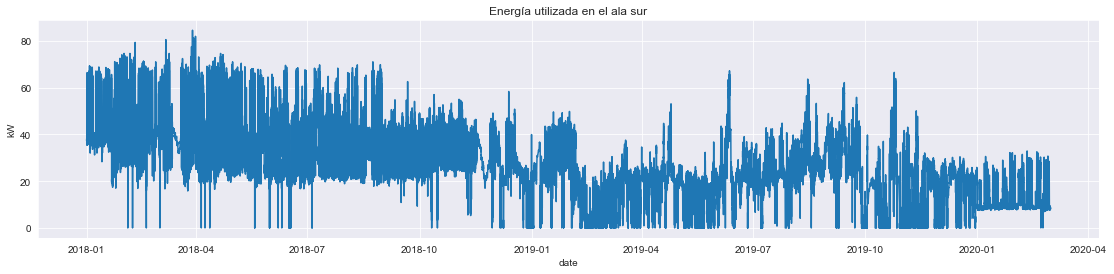

In [31]:
plt.figure(figsize=(19,4))
sns.lineplot(x =energy_use.index , y=energy_use[var])
plt.ylabel('kW')

plt.title('Energía utilizada en el ala sur')

In [8]:
# We crop until March 2020, since it's the expected normal use (covid effect)

energy_use=energy_use[energy_use.index < '2020-03-01 00:00:00']


In [9]:
energy_use = energy_use.resample('15T').mean()





### ARIMA 

We will fit a very basic ARIMA model into this variable, and we will study its behaviour. Since we have seasonality in our data, we will also use SARIMA and compare the results of fitting both models.
For this model, we have to decide the value of the main parameters:
- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.




In [10]:
#Split into train and test:

df_train = energy_use.iloc[:-2000,:][var]
df_test = energy_use.iloc[-2000:, :][var]

In [11]:
import warnings
warnings.filterwarnings("ignore")

First, we will implement a model that has as a train set 75% of the whole set, and forecasts the next 25% of the samples in one single take.


In [14]:
model_arima_inicial = ARIMA(df_train, order =(1,3,2))
model_arima_inicial_fit = model_arima_inicial.fit()
print(model_arima_inicial_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                 hvac_N   No. Observations:                73836
Model:                 ARIMA(1, 3, 2)   Log Likelihood             -243013.839
Date:                Tue, 07 Mar 2023   AIC                         486035.678
Time:                        15:38:29   BIC                         486072.517
Sample:                    01-01-2018   HQIC                        486047.012
                         - 02-09-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4341      0.002   -219.405      0.000      -0.438      -0.430
ma.L1         -1.9685      0.001  -2532.255      0.000      -1.970      -1.967
ma.L2          0.9747      0.001   1256.942      0.0

Next, we will plot the residuals (necessary to check if there are patterns):


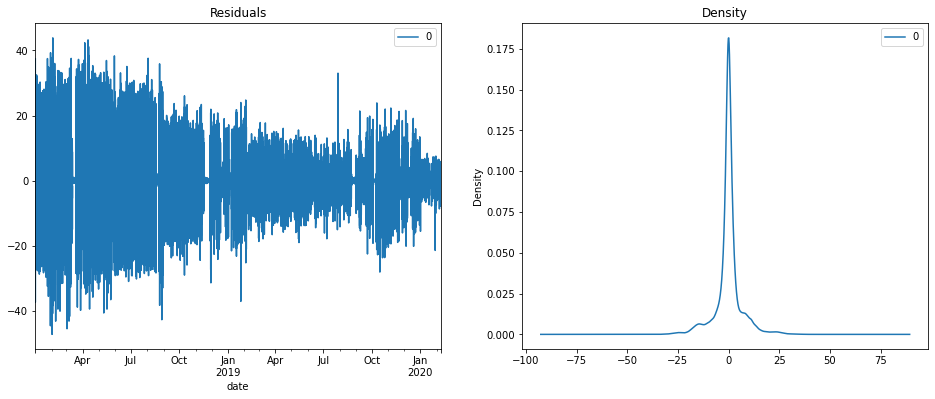

In [16]:
# Plot residual errors
residuals = pd.DataFrame(model_arima_inicial_fit.resid)
fig, ax= plt.subplots(nrows=1,ncols=2, figsize=(16,6) )
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

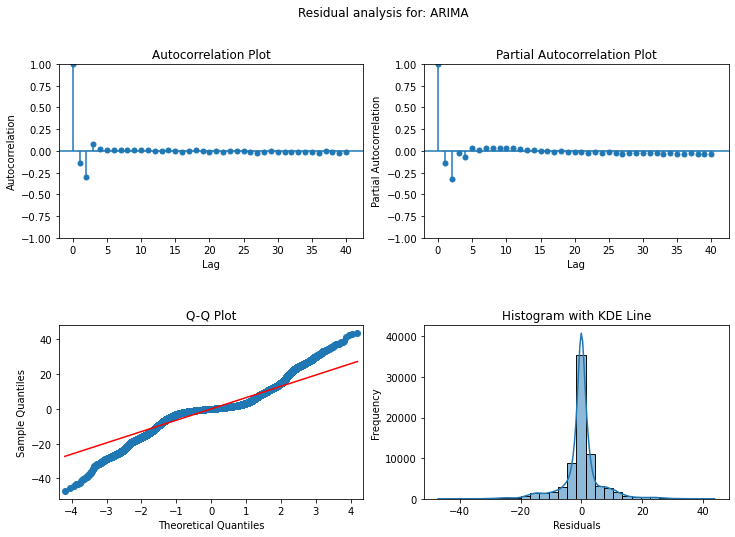

The residuals do not follow a normal distribution (p-value = 0.00000000000000000000, alpha = 0.05)
The residuals are autocorrelated (some p-values < alpha = 0.0500000000)
           lb_stat  lb_pvalue
1      1513.960894        0.0
2      7995.144784        0.0
3      8518.173539        0.0
4      8570.624828        0.0
5      8580.801729        0.0
...            ...        ...
8068  30650.510008        0.0
8069  30652.170478        0.0
8070  30661.642381        0.0
8071  30664.273859        0.0
8072  30664.301378        0.0

[8072 rows x 2 columns]
Durbin Watson:  2.285933368058768
No autocorrelation


In [19]:
residual_analysis(model_arima_inicial_fit.resid, title="ARIMA")

We want to plot the predictions of the model starting for the test set. We will also check if a dynamic forecasting works better than static one.

In [23]:
df_test

date
2020-02-09 04:00:00    8.296667
2020-02-09 04:15:00    9.098000
2020-02-09 04:30:00    8.350000
2020-02-09 04:45:00    8.533333
2020-02-09 05:00:00    8.725714
                         ...   
2020-02-29 22:45:00    8.618000
2020-02-29 23:00:00    8.316667
2020-02-29 23:15:00    8.560000
2020-02-29 23:30:00    8.020000
2020-02-29 23:45:00    8.022500
Freq: 15T, Name: hvac_N, Length: 2000, dtype: float64

In [21]:
energy_use.iloc[-(df_test.shape[0]-1000):,:]

,mels_S,lig_S,mels_N,hvac_N,hvac_S
date,,,,,
2020-02-19 14:00:00,2.800000,2.911111,4.486029,9.573750,22.726667
2020-02-19 14:15:00,2.700000,2.900000,4.933986,10.327143,25.527778
2020-02-19 14:30:00,2.625000,3.400000,4.901590,9.962727,23.973684
2020-02-19 14:45:00,4.198333,3.585714,5.194832,9.727143,23.070000
2020-02-19 15:00:00,5.366667,3.600000,5.358859,9.615000,22.841579
...,...,...,...,...,...
2020-02-29 22:45:00,0.700000,0.020000,1.225181,8.618000,16.100000
2020-02-29 23:00:00,0.733333,0.010000,1.623994,8.316667,21.100000
2020-02-29 23:15:00,0.660000,0.010000,1.222089,8.560000,19.918000


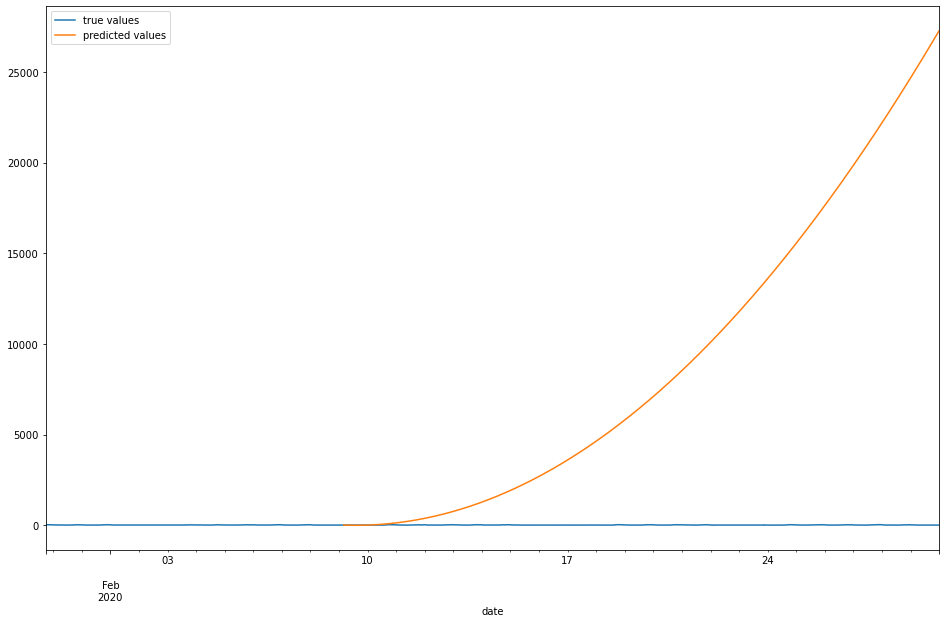

In [47]:
plot_zoom(model_arima_inicial_fit, energy_use, df_test,len(df_train), var)

We see that the model is not performing well. This can be due to the current train-test split. We are going to add some more samples to the test set so that the end of the train set doesn't end in the constant line that we can see in the plot. 

                               SARIMAX Results                                
Dep. Variable:                 hvac_N   No. Observations:                73336
Model:                 ARIMA(1, 3, 2)   Log Likelihood             -241598.934
Date:                Tue, 07 Mar 2023   AIC                         483205.867
Time:                        16:06:41   BIC                         483242.678
Sample:                    01-01-2018   HQIC                        483217.197
                         - 02-03-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4343      0.002   -218.127      0.000      -0.438      -0.430
ma.L1         -1.9685      0.001  -2520.199      0.000      -1.970      -1.967
ma.L2          0.9747      0.001   1250.950      0.0

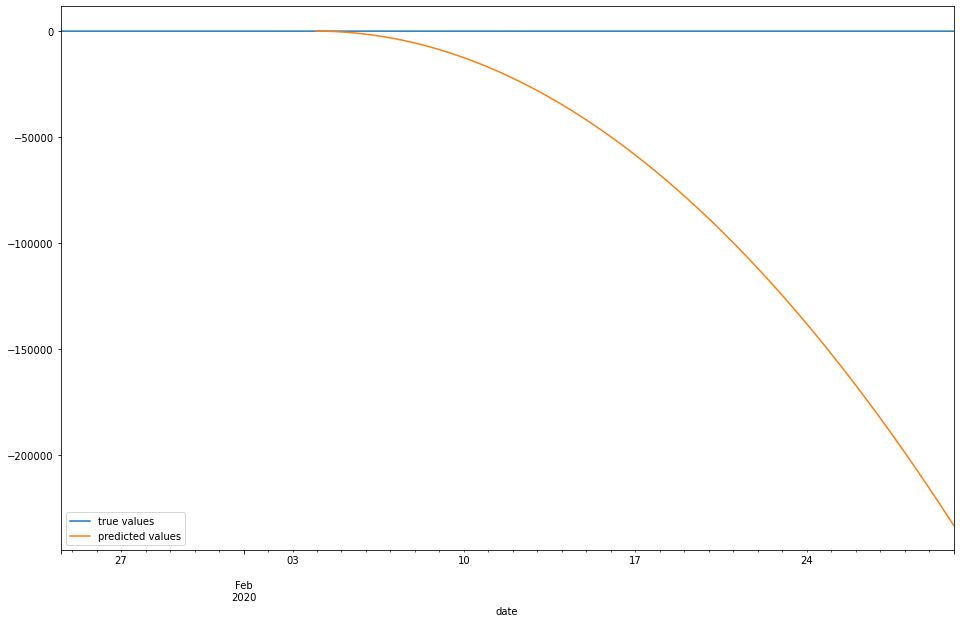

In [48]:
#Split into train and test:

df_train_2 = energy_use.iloc[:-2500,:][var]
df_test_2 = energy_use.iloc[-2500:, :][var]

model_arima_2 = ARIMA(df_train_2, order =(1,3,2))
model_arima_2_fit = model_arima_2.fit()
print(model_arima_2_fit.summary())

plot_zoom(model_arima_2_fit,energy_use, df_test_2,len(df_train_2), var)

The problem was not the split, the behaviour of the model is still very bad.

In [29]:
start = df_train_2.index[50000]
end = df_train_2.index[-1]


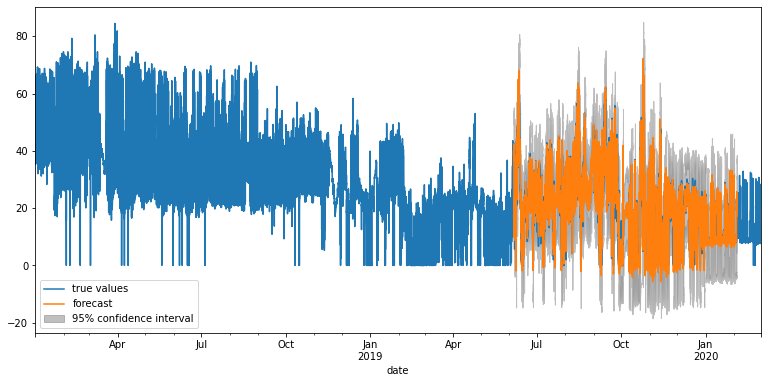

In [30]:
# Actual vs Fitte
fig, ax = plt.subplots(figsize=(13,6))

ax = energy_use[var].plot(label ='true values', ax=ax)

fig = plot_predict(model_arima_2_fit, start = start, end = end, ax = ax)
#ax.set_xlim(['2019-01', '2019-02'])
plt.show()

The model is overfitting our training data. We are going to try to use a bigger test set:

                               SARIMAX Results                                
Dep. Variable:                 hvac_N   No. Observations:                65836
Model:                 ARIMA(1, 3, 2)   Log Likelihood             -219854.568
Date:                Tue, 07 Mar 2023   AIC                         439717.136
Time:                        16:07:06   BIC                         439753.516
Sample:                    01-01-2018   HQIC                        439728.388
                         - 11-17-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4382      0.002   -200.725      0.000      -0.443      -0.434
ma.L1         -1.9698      0.001  -2443.631      0.000      -1.971      -1.968
ma.L2          0.9762      0.001   1213.763      0.0

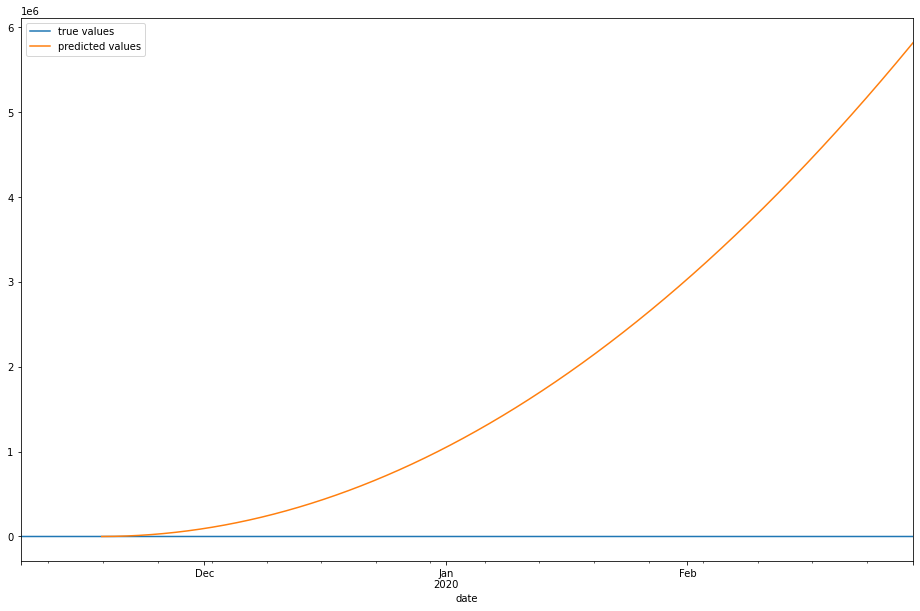

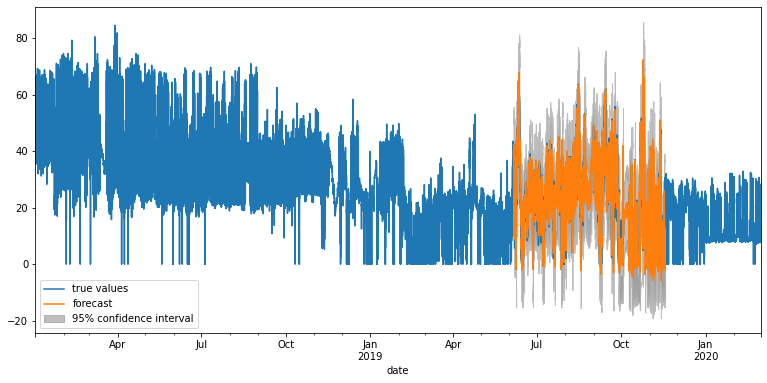

In [49]:
#Split into train and test:

df_train_3 = energy_use.iloc[:-10000,:][var]
df_test_3 = energy_use.iloc[-10000:, :][var]

model_arima_3 = ARIMA(df_train_3, order =(1,3,2))
model_arima_3_fit = model_arima_3.fit()
print(model_arima_3_fit.summary())

plot_zoom(model_arima_3_fit,energy_use, df_test_3,len(df_train_3), var)



start = df_train_3.index[50000]
end = df_train_3.index[-1]

# Actual vs Fitte
fig, ax = plt.subplots(figsize=(13,6))

ax = energy_use[var].plot(label ='true values', ax=ax)

fig = plot_predict(model_arima_3_fit, start = start, end = end, ax = ax)
#ax.set_xlim(['2019-01', '2019-02'])
plt.show()

##### Evaluation metrics

We will check the train and test evaluation metrics: MAE (Mean Absolute Error), MAPE (Mean Absolute Percentage Error), and RMSE (Root Mean Squared Error). As we have seen in previous plots, the behaviour in train and test sets is very different:

In [34]:
print("TRAIN SET METRICS")
train_forecast = model_arima_inicial_fit.predict(start=df_train.index[0], end=df_train.index[-1])
mae = mean_absolute_error(df_train, train_forecast)
mape = mean_absolute_percentage_error(df_train, train_forecast)
rmse = np.sqrt(mean_squared_error(df_train, train_forecast))

print(f'mae: {mae}')
print(f'mape: {mape}')
print(f'rmse: {rmse}')

TRAIN SET METRICS
mae: 3.8120137570508836
mape: 10.721432545733768
rmse: 6.506595690317276


In [35]:
print("TEST SET METRICS")
test_forecast = model_arima_inicial_fit.forecast(len(df_test))
mae = mean_absolute_error(df_test, test_forecast)
mape = mean_absolute_percentage_error(df_test, test_forecast)
rmse = np.sqrt(mean_squared_error(df_test, test_forecast))

print(f'mae: {mae}')
print(f'mape: {mape}')
print(f'rmse: {rmse}')

TEST SET METRICS
mae: 8893.065800033783
mape: 2016.2991608232564
rmse: 12061.099481279167


Clearly, we have overfitting, this means that the model is not able to correctly predict outside of the training set.

#### Parameter tuning
Even if we didn't acheive great results with ARIMA, we will try to tune the parameters, comparing models with the AIC and BIC metrics:

In [36]:
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-2
for p in range(0, 3):

  for d in range(0,3):
  # Loop over q values from 0-2
    for q in range(0, 3):
        print("Model: \np=", p,"\nd=", d, "\nq=", q)
      	# create and fit ARMA(p,q) model
        model = ARIMA(df_train, order=(p,d,q))
        results = model.fit()
        
        # Append order and results tuple
        order_aic_bic.append((p, d, q, results.aic, results.bic))

Model: 
p= 0 
d= 0 
q= 0
Model: 
p= 0 
d= 0 
q= 1
Model: 
p= 0 
d= 0 
q= 2
Model: 
p= 0 
d= 1 
q= 0
Model: 
p= 0 
d= 1 
q= 1
Model: 
p= 0 
d= 1 
q= 2
Model: 
p= 0 
d= 2 
q= 0
Model: 
p= 0 
d= 2 
q= 1
Model: 
p= 0 
d= 2 
q= 2
Model: 
p= 1 
d= 0 
q= 0
Model: 
p= 1 
d= 0 
q= 1
Model: 
p= 1 
d= 0 
q= 2
Model: 
p= 1 
d= 1 
q= 0
Model: 
p= 1 
d= 1 
q= 1
Model: 
p= 1 
d= 1 
q= 2
Model: 
p= 1 
d= 2 
q= 0
Model: 
p= 1 
d= 2 
q= 1
Model: 
p= 1 
d= 2 
q= 2
Model: 
p= 2 
d= 0 
q= 0
Model: 
p= 2 
d= 0 
q= 1
Model: 
p= 2 
d= 0 
q= 2
Model: 
p= 2 
d= 1 
q= 0
Model: 
p= 2 
d= 1 
q= 1
Model: 
p= 2 
d= 1 
q= 2
Model: 
p= 2 
d= 2 
q= 0
Model: 
p= 2 
d= 2 
q= 1
Model: 
p= 2 
d= 2 
q= 2


In [37]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p','d','q','AIC','BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values(by='AIC', ascending=True))



    p  d  q            AIC            BIC
23  2  1  2  467347.503918  467393.551859
22  2  1  1  467422.322562  467459.160914
20  2  0  2  467428.178736  467483.436346
26  2  2  2  467434.868760  467480.916633
11  1  0  2  467655.058233  467701.106241
19  2  0  1  467655.658095  467701.706104
10  1  0  1  467655.764144  467692.602551
14  1  1  2  467694.437817  467731.276170
4   0  1  1  467931.105171  467949.524347
5   0  1  2  467932.637613  467960.266377
13  1  1  1  467932.736202  467960.364967
17  1  2  2  467943.622318  467980.460616
8   0  2  2  467945.672241  467973.300965
21  2  1  0  471856.158749  471883.787514
25  2  2  1  471865.582698  471902.420996
18  2  0  0  480138.904171  480175.742578
12  1  1  0  482034.447649  482052.866826
16  1  2  1  482046.138996  482073.767720
9   1  0  0  493784.376710  493812.005515
3   0  1  0  498551.235445  498560.445033
7   0  2  1  498559.719758  498578.138907
24  2  2  0  515659.186170  515686.814893
2   0  0  2  533188.775153  533225

In [39]:
print(order_df.sort_values(by='BIC', ascending=True))


    p  d  q            AIC            BIC
23  2  1  2  467347.503918  467393.551859
22  2  1  1  467422.322562  467459.160914
26  2  2  2  467434.868760  467480.916633
20  2  0  2  467428.178736  467483.436346
10  1  0  1  467655.764144  467692.602551
11  1  0  2  467655.058233  467701.106241
19  2  0  1  467655.658095  467701.706104
14  1  1  2  467694.437817  467731.276170
4   0  1  1  467931.105171  467949.524347
5   0  1  2  467932.637613  467960.266377
13  1  1  1  467932.736202  467960.364967
8   0  2  2  467945.672241  467973.300965
17  1  2  2  467943.622318  467980.460616
21  2  1  0  471856.158749  471883.787514
25  2  2  1  471865.582698  471902.420996
18  2  0  0  480138.904171  480175.742578
12  1  1  0  482034.447649  482052.866826
16  1  2  1  482046.138996  482073.767720
9   1  0  0  493784.376710  493812.005515
3   0  1  0  498551.235445  498560.445033
7   0  2  1  498559.719758  498578.138907
24  2  2  0  515659.186170  515686.814893
2   0  0  2  533188.775153  533225

We will repeat previous steps with ARIMA(2,1,2)

                               SARIMAX Results                                
Dep. Variable:                 hvac_N   No. Observations:                73836
Model:                 ARIMA(2, 2, 2)   Log Likelihood             -233712.434
Date:                Tue, 07 Mar 2023   AIC                         467434.869
Time:                        16:07:44   BIC                         467480.917
Sample:                    01-01-2018   HQIC                        467449.036
                         - 02-09-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0918      0.004    -23.043      0.000      -0.100      -0.084
ar.L2         -0.1219      0.003    -40.161      0.000      -0.128      -0.116
ma.L1         -1.6238      0.004   -442.034      0.0

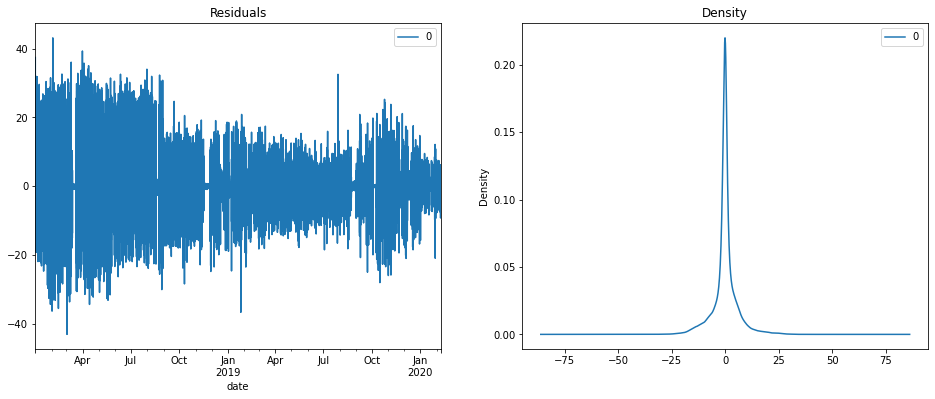

TRAIN SET METRICS
mae: 3.4115135847154496
mape: 9.740218791871987
rmse: 5.736095341109282
TEST SET METRICS
mae: 5.060123344867008
mape: 1.0300500294746215
rmse: 8.428193431516236


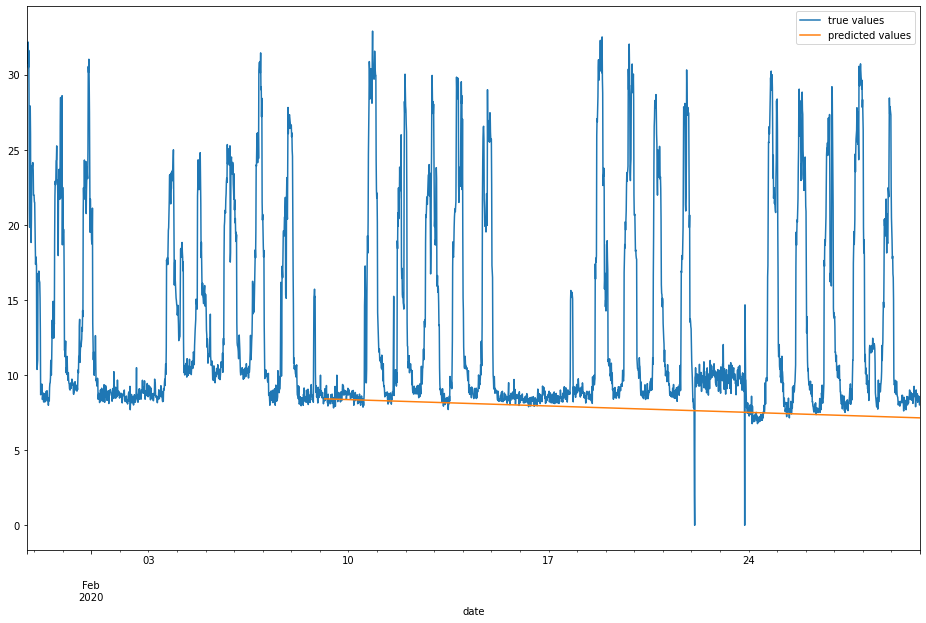

In [50]:
model_arima_tuned = ARIMA(df_train, order =(2,1,2))
model_arima_tuned_fit = model.fit()
print(model_arima_tuned_fit.summary())


# Plot residual errors
residuals = pd.DataFrame(model_arima_tuned_fit.resid)
fig, ax= plt.subplots(nrows=1,ncols=2, figsize=(16,6) )
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

plot_zoom(model_arima_tuned_fit, energy_use, df_test, len(df_train), var)
metrics(model_arima_tuned_fit, df_test, df_train)




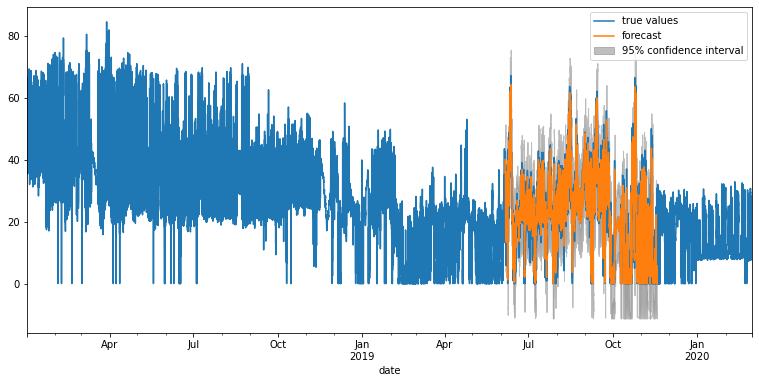

In [41]:
# Actual vs Fitte
fig, ax = plt.subplots(figsize=(13,6))

ax = energy_use[var].plot(label ='true values', ax=ax)

fig = plot_predict(model_arima_tuned_fit, start = start, end = end, ax = ax)
#ax.set_xlim(['2019-01', '2019-02'])
plt.show()

### SARIMAX
We have multiple seasonal components, so probably SARIMAX will not be an adequate option

In [42]:
sarimax_mod = sm.tsa.statespace.SARIMAX(energy_use[var],order=(2,1,2),
                                                seasonal_order=(2,1,2,4),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

sarimax_fit = sarimax_mod.fit(maxiter=50) 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29511D+00    |proj g|=  8.07124D-02

At iterate    5    f=  3.24459D+00    |proj g|=  8.61953D-02

At iterate   10    f=  3.17912D+00    |proj g|=  1.84195D-01

At iterate   15    f=  3.15420D+00    |proj g|=  1.62962D-01

At iterate   20    f=  3.15335D+00    |proj g|=  9.01001D-03

At iterate   25    f=  3.15334D+00    |proj g|=  3.50059D-03

At iterate   30    f=  3.15329D+00    |proj g|=  4.65597D-03

At iterate   35    f=  3.15320D+00    |proj g|=  7.95751D-03

At iterate   40    f=  3.15315D+00    |proj g|=  1.23624D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

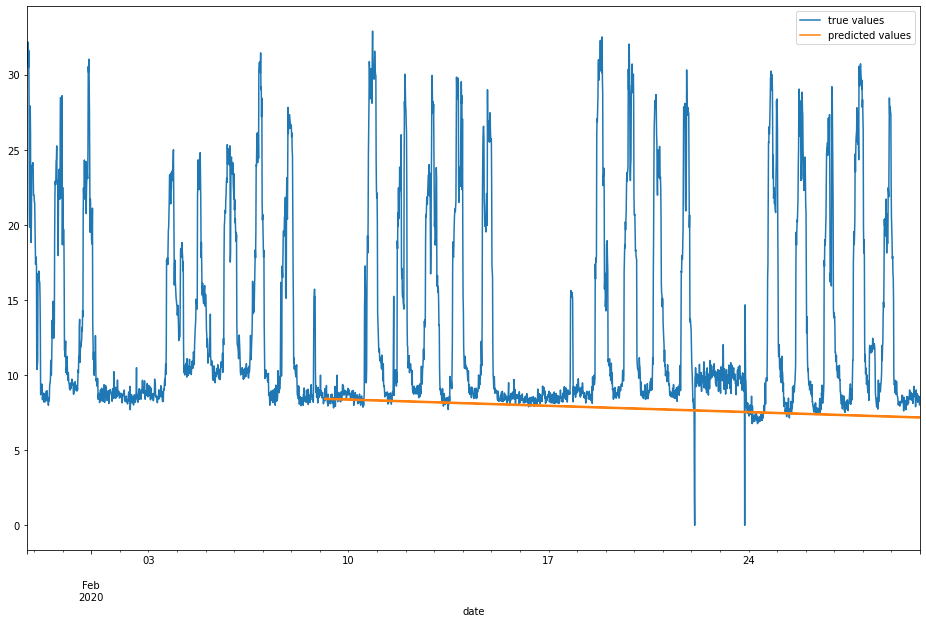

In [51]:
plot_zoom(sarimax_fit, energy_use, df_test,len(df_train),var)

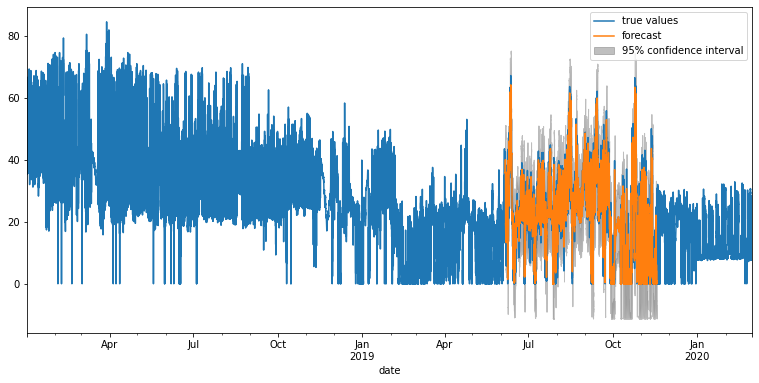

In [44]:

# Actual vs Fitte
fig, ax = plt.subplots(figsize=(13,6))

ax = energy_use[var].plot(label ='true values', ax=ax)

fig = plot_predict(sarimax_fit, start = start, end = end, ax = ax)
#ax.set_xlim(['2019-01', '2019-02'])
plt.legend()
plt.show()

Next, we will compare the MSE of both models:

In [45]:
metrics(sarimax_fit, df_test, df_train)

TRAIN SET METRICS
mae: 3.420660893777796
mape: 9.897882194247527
rmse: 5.734174360284326
TEST SET METRICS
mae: 5.184606048274385
mape: 1.031908494092399
rmse: 8.509291373254456


### Prophet
We will try a very simple model and check if we still have overfitting:

In [45]:
from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics

In [39]:

df_train_p = df_train.reset_index()
df_train_p.columns=['ds', 'y']
df_test_p = df_test.reset_index()
df_test_p.columns=['ds', 'y']

In [31]:
model = Prophet(changepoint_range=0.9)
model.add_seasonality(name='hourly', period=4, fourier_order=3)
model.fit(df_train_p )

16:36:55 - cmdstanpy - INFO - Chain [1] start processing
16:37:26 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
#Out of sample forecast
future = df_test_p[['ds']]
forecast = model.predict(future)

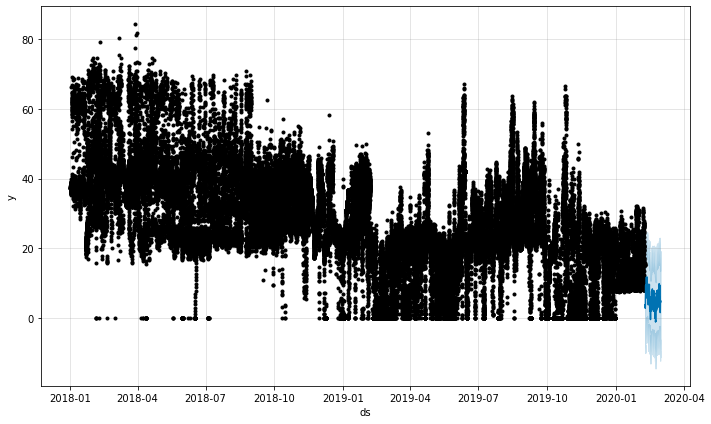

In [33]:
fig1 = model.plot(forecast)


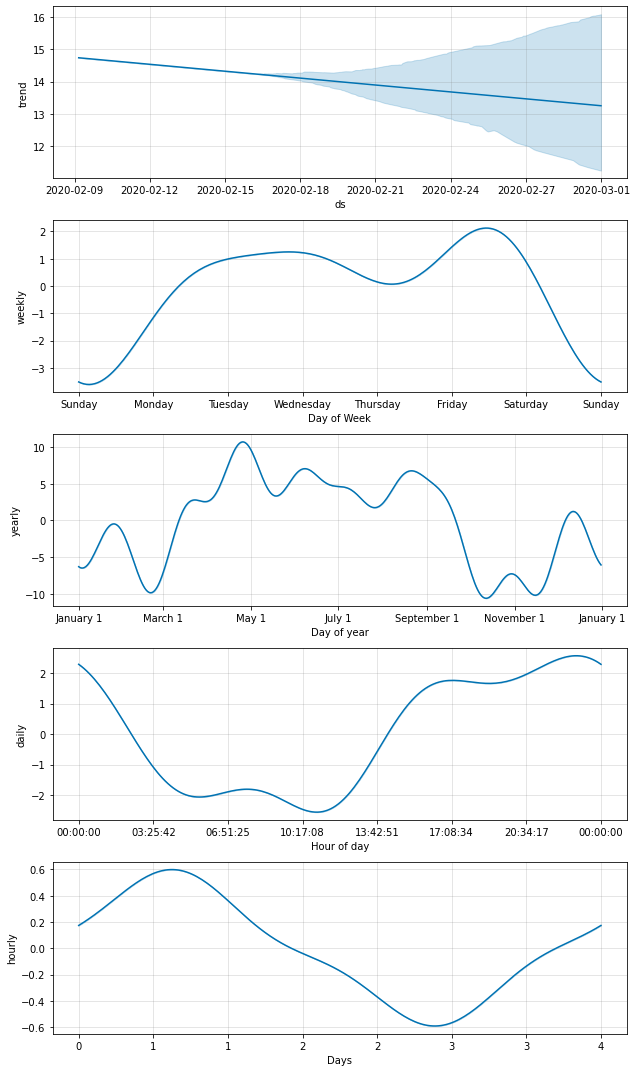

In [34]:
fig2 = model.plot_components(forecast)


In [35]:
from prophet.plot import plot_plotly, plot_components_plotly



Next, we will check the in sample predictions


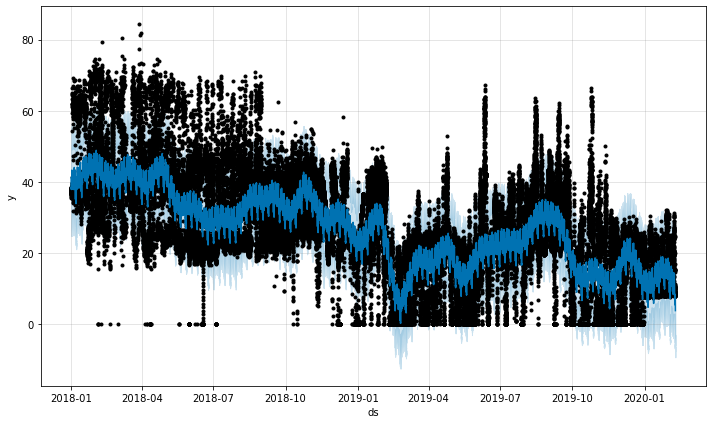

In [36]:
#Out of sample forecast
future = df_train_p[['ds']]
forecast = model.predict(future)
fig1 = model.plot(forecast)


We see that it picks up some of the movement of the time series, but not really, since it doesn't model all the peaks.

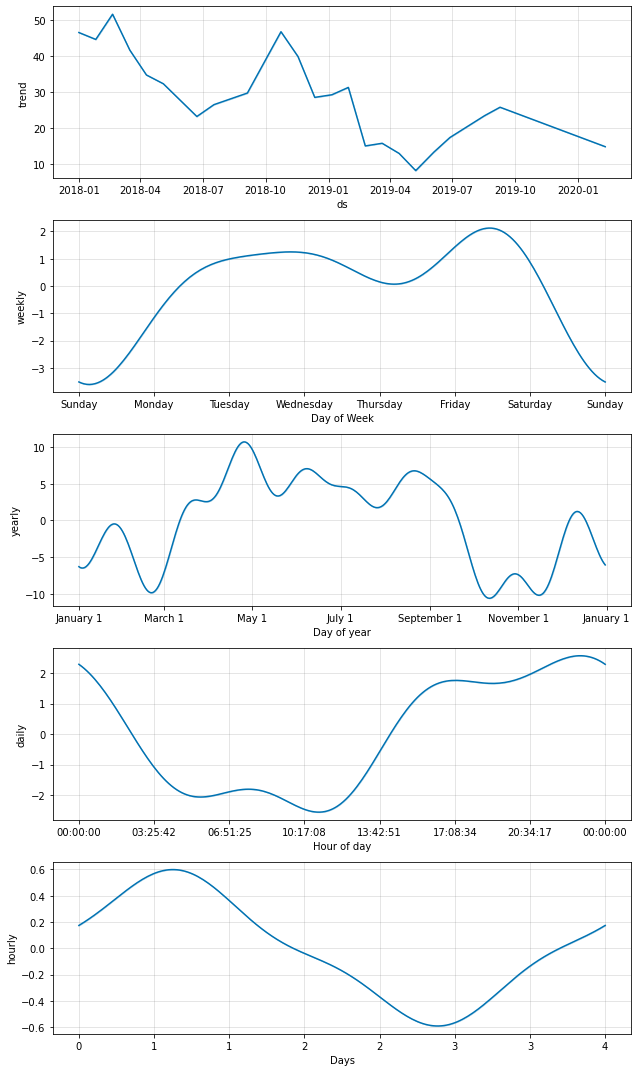

In [37]:
fig2 = model.plot_components(forecast)


Now we will repeat some of the plots we had with previous models, so we can compare them:


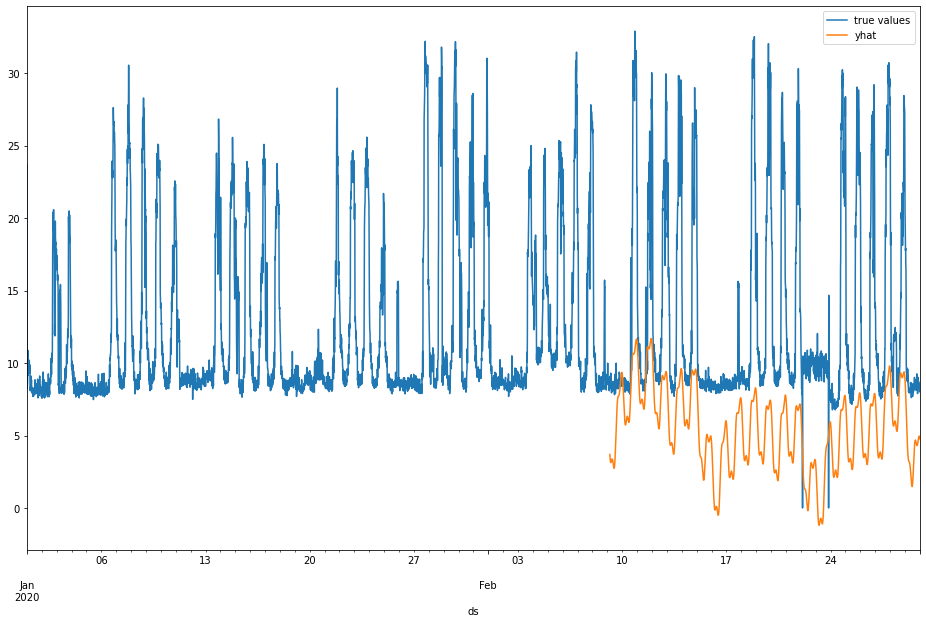

In [38]:
plt.figure(figsize=(16, 10))
df = energy_use
#Out of sample forecast
future = df_test_p[['ds']]
forecast = model.predict(future)[['ds', 'yhat']].set_index('ds')
ax = df[df.index.year == 2020][var].plot(label='true values')
forecast.plot(label='predicted values', ax=ax)
plt.legend()

In [41]:
# We are going to do cross validation

model_prophet_cv = cross_validation(model, initial='380 days', period='30 days', horizon = '30 days', parallel="processes")
# Model performance metrics
model_prophet_cv_metrics = performance_metrics(model_prophet_cv, rolling_window=1)

16:41:42 - cmdstanpy - INFO - Chain [1] start processing
16:41:43 - cmdstanpy - INFO - Chain [1] start processing
16:41:43 - cmdstanpy - INFO - Chain [1] start processing
16:42:00 - cmdstanpy - INFO - Chain [1] start processing
16:42:01 - cmdstanpy - INFO - Chain [1] start processing
16:42:02 - cmdstanpy - INFO - Chain [1] start processing
16:42:03 - cmdstanpy - INFO - Chain [1] start processing
16:42:04 - cmdstanpy - INFO - Chain [1] start processing
16:42:05 - cmdstanpy - INFO - Chain [1] start processing
16:42:05 - cmdstanpy - INFO - Chain [1] start processing
16:42:06 - cmdstanpy - INFO - Chain [1] start processing
16:44:27 - cmdstanpy - INFO - Chain [1] done processing
16:44:29 - cmdstanpy - INFO - Chain [1] done processing
16:44:45 - cmdstanpy - INFO - Chain [1] start processing
16:44:48 - cmdstanpy - INFO - Chain [1] start processing
16:45:31 - cmdstanpy - INFO - Chain [1] done processing
16:45:49 - cmdstanpy - INFO - Chain [1] start processing
16:47:16 - cmdstanpy - INFO - Chai

In [43]:
model_prophet_cv_metrics

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,275.924637,16.610979,12.539564,135.626128,0.633304,0.85046,0.589439


In [44]:
# Set up parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# Create a list to store MAPE values for each combination
mapes = [] 
# Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params).fit(df_train_p)  
    # Cross-validation
    df_cv = cross_validation(m, initial='360 days', period='80 days', horizon = '100 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    mapes.append(df_p['mape'].values[0])
    
# Tuning results
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
# Find the best parameters
best_params = all_params[np.argmin(mapes)]
print(best_params)

16:56:10 - cmdstanpy - INFO - Chain [1] start processing
16:56:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
16:56:25 - cmdstanpy - INFO - Chain [1] start processing
16:56:25 - cmdstanpy - INFO - Chain [1] start processing
16:56:26 - cmdstanpy - INFO - Chain [1] start processing
16:56:26 - cmdstanpy - INFO - Chain [1] start processing
16:56:29 - cmdstanpy - INFO - Chain [1] done processing
16:56:31 - cmdstanpy - INFO - Chain [1] done processing
16:56:31 - cmdstanpy - INFO - Chain [1] done processing
16:56:32 - cmdstanpy - INFO - Chain [1] done processing
16:56:38 - cmdstanpy - INFO - Chain [1] start processing
16:56:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
16:56:46 - cmdstanpy - INFO - Chain [1] start processing
16:56:47 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


In [45]:
auto_model = Prophet(changepoint_prior_scale=0.5, 
                     seasonality_prior_scale=0.01, 
                     seasonality_mode='multiplicative')
# Fit the model on the training dataset
auto_model.fit(df_train_p)
# Cross validation
auto_model_cv = cross_validation(auto_model, initial='370 days', period='80 days', horizon = '100 days', parallel="processes")
# Model performance metrics
auto_model_p = performance_metrics(auto_model_cv, rolling_window=1)


22:36:18 - cmdstanpy - INFO - Chain [1] start processing
22:36:57 - cmdstanpy - INFO - Chain [1] done processing
22:37:02 - cmdstanpy - INFO - Chain [1] start processing
22:37:02 - cmdstanpy - INFO - Chain [1] start processing
22:37:03 - cmdstanpy - INFO - Chain [1] start processing
22:37:03 - cmdstanpy - INFO - Chain [1] start processing
22:37:45 - cmdstanpy - INFO - Chain [1] done processing
22:37:57 - cmdstanpy - INFO - Chain [1] done processing
22:38:22 - cmdstanpy - INFO - Chain [1] done processing
22:38:23 - cmdstanpy - INFO - Chain [1] done processing


In [46]:
print(auto_model_p)

   horizon         mse       rmse        mae        mape     mdape     smape  \
0 100 days  337.593728  18.373724  14.673543  226.795248  0.748533  1.087091   

   coverage  
0  0.925312  


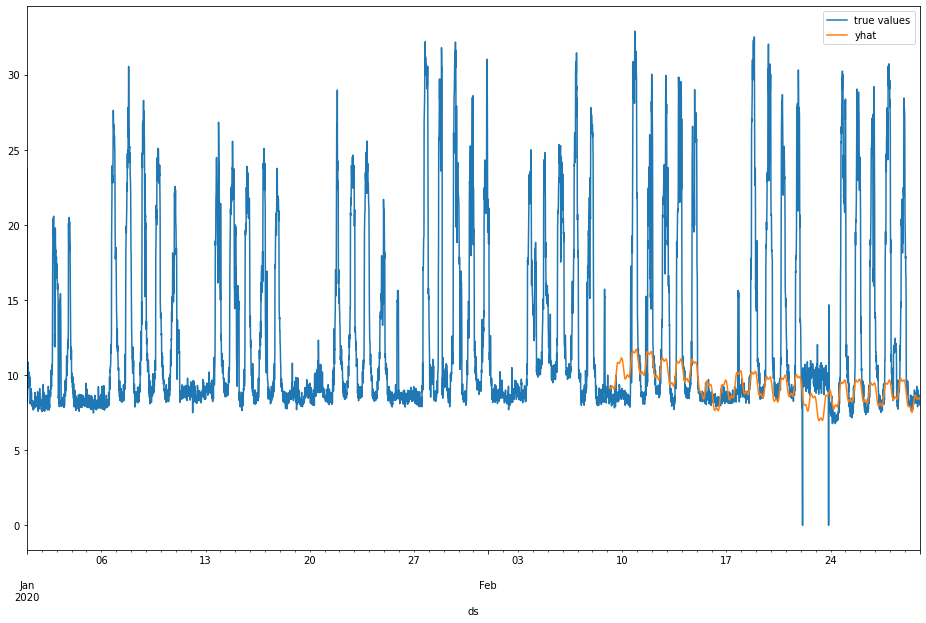

In [47]:
plt.figure(figsize=(16, 10))
df = energy_use
#Out of sample forecast
future = df_test_p[['ds']]
forecast = auto_model.predict(future)[['ds', 'yhat']].set_index('ds')
ax = df[df.index.year == 2020][var].plot(label='true values')
forecast.plot(label='predicted values', ax=ax)
plt.legend()

#### Parameter tuning with log transformation

In [50]:
df_test_p['y_log'] = np.log(df_test_p['y'])
df_train_p['y_log'] = np.log(df_train_p['y'])


In [51]:
df_train_p_log = df_train_p[['ds', 'y_log']].rename(columns={'y_log': 'y'}).copy()
df_test_p_log = df_test_p[['ds', 'y_log']].rename(columns={'y_log': 'y'}).copy()

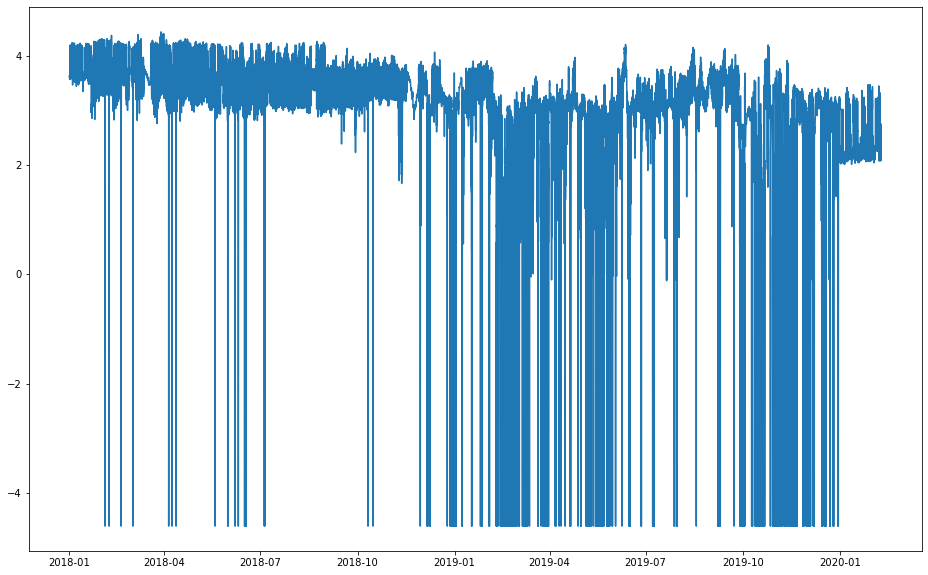

In [52]:
# We plot the new data
plt.figure(figsize=(16, 10))
plt.plot(df_train_p_log['ds'], df_train_p_log['y'], label='train')

In [57]:
df_p

,horizon,mse,rmse,mae,mdape,smape,coverage
0,100 days,6.154361,2.480798,1.773504,0.444454,0.7009,0.763776


In [58]:

# Create a list to store MAPE values for each combination
mapes_log = [] 
# Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params).fit(df_train_p_log)  
    # Cross-validation
    df_cv = cross_validation(m, initial='370 days', period='80 days', horizon = '100 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    mapes_log.append(df_p['smape'].values[0])
    
# Tuning results
tuning_results_log = pd.DataFrame(all_params)
tuning_results_log['smape'] = mapes_log
# Find the best parameters
best_params_log = all_params[np.argmin(mapes_log)]
print(best_params_log)

22:56:50 - cmdstanpy - INFO - Chain [1] start processing
22:56:55 - cmdstanpy - INFO - Chain [1] done processing
22:56:59 - cmdstanpy - INFO - Chain [1] start processing
22:57:00 - cmdstanpy - INFO - Chain [1] start processing
22:57:00 - cmdstanpy - INFO - Chain [1] start processing
22:57:01 - cmdstanpy - INFO - Chain [1] start processing
22:57:03 - cmdstanpy - INFO - Chain [1] done processing
22:57:05 - cmdstanpy - INFO - Chain [1] done processing
22:57:06 - cmdstanpy - INFO - Chain [1] done processing
22:57:06 - cmdstanpy - INFO - Chain [1] done processing
22:57:12 - cmdstanpy - INFO - Chain [1] start processing
22:57:15 - cmdstanpy - INFO - Chain [1] done processing
22:57:19 - cmdstanpy - INFO - Chain [1] start processing
22:57:19 - cmdstanpy - INFO - Chain [1] start processing
22:57:20 - cmdstanpy - INFO - Chain [1] start processing
22:57:20 - cmdstanpy - INFO - Chain [1] start processing
22:57:23 - cmdstanpy - INFO - Chain [1] done processing
22:57:24 - cmdstanpy - INFO - Chain [1

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:30 - cmdstanpy - INFO - Chain [1] start processing
00:12:33 - cmdstanpy - INFO - Chain [1] done processing
00:12:37 - cmdstanpy - INFO - Chain [1] start processing
00:12:37 - cmdstanpy - INFO - Chain [1] start processing
00:12:38 - cmdstanpy - INFO - Chain [1] start processing
00:12:38 - cmdstanpy - INFO - Chain [1] start processing
00:12:41 - cmdstanpy - INFO - Chain [1] done processing
00:12:42 - cmdstanpy - INFO - Chain [1] done processing
00:12:43 - cmdstanpy - INFO - Chain [1] done processing
00:12:44 - cmdstanpy - INFO - Chain [1] done processing


   horizon       mse      rmse       mae     mdape     smape  coverage
0 100 days  5.779219  2.404001  1.652964  0.380393  0.617623  0.846042


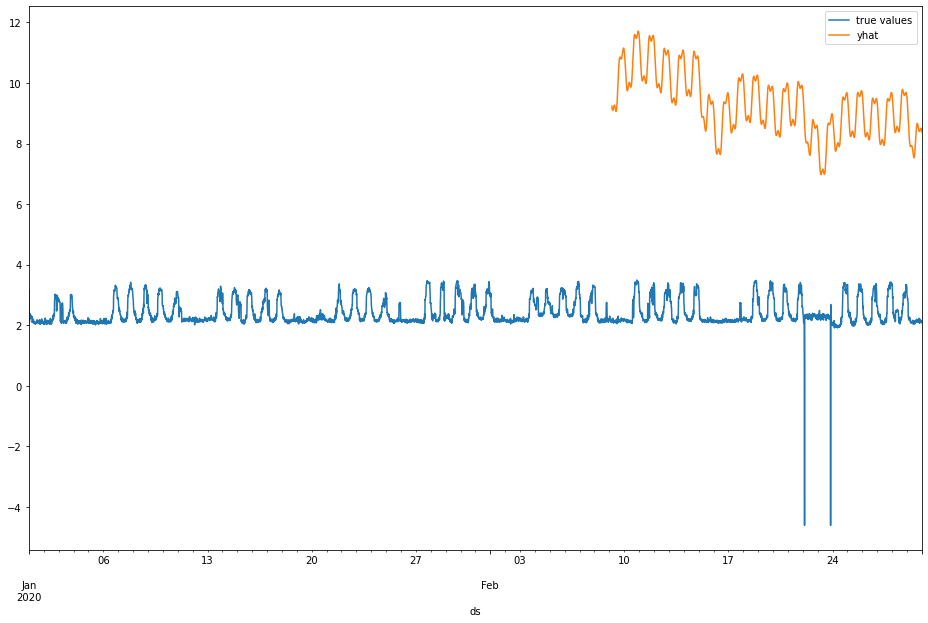

In [59]:
auto_model_log = Prophet(changepoint_prior_scale=0.001, 
                     seasonality_prior_scale=0.01, 
                     seasonality_mode='multiplicative')
# Fit the model on the training dataset
auto_model_log.fit(df_train_p_log)
# Cross validation
auto_model_log_cv = cross_validation(auto_model_log, initial='370 days', period='80 days', horizon = '100 days', parallel="processes")
# Model performance metrics
auto_model_log_p = performance_metrics(auto_model_log_cv, rolling_window=1)

print(auto_model_log_p)
plt.figure(figsize=(16, 10))
df = energy_use
#Out of sample forecast
future = df_test_p_log[['ds']]
forecast = auto_model.predict(future)[['ds', 'yhat']].set_index('ds')
ax = np.log(df[df.index.year == 2020][var]).plot(label='true values')
forecast.plot(label='predicted values', ax=ax)
plt.legend()

#### Box-Cox transformation

We want to check if the optimal box-cox transformation is the log transformation, which we have already tried. 

In [34]:
from scipy.stats import boxcox

box_cox_df,lam = boxcox(energy_use[var])
print('Lambda: %f' % lam)


Lambda: 0.673416


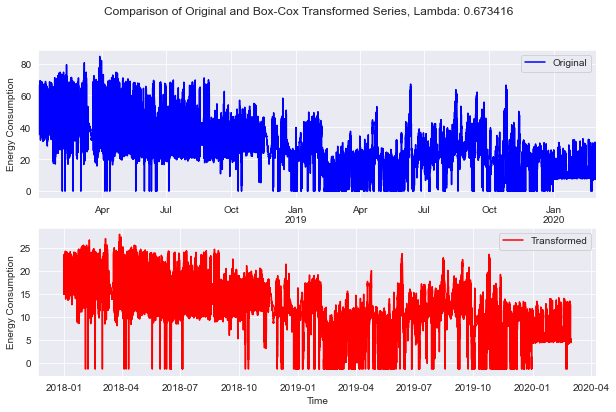

In [35]:
fig, ax = plt.subplots(2,1,figsize=(10,6))

# plot the original series
energy_use[var].plot(ax=ax[0], color='blue', label='Original')

# plot the transformed series
sns.lineplot(ax=ax[1],y=box_cox_df, x=energy_use[var].index, color='red', label='Transformed')

# set the axis labels and title
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Energy Consumption')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Energy Consumption')
plt.suptitle('Comparison of Original and Box-Cox Transformed Series, Lambda: %f' % lam)

# add a legend
ax[0].legend()

# show the plot
plt.show()

In [42]:
box_cox_df = pd.DataFrame(box_cox_df, columns=[var], index=energy_use.index)
box_cox_train = box_cox_df.iloc[:-2000,:][[var]].reset_index().rename(columns={var: 'y', 'date':'ds'})
box_cox_test = box_cox_df.iloc[-2000:, :][[var]].reset_index().rename(columns={var: 'y', 'date':'ds'})

12:48:02 - cmdstanpy - INFO - Chain [1] start processing
12:48:32 - cmdstanpy - INFO - Chain [1] done processing
12:48:37 - cmdstanpy - INFO - Chain [1] start processing
12:48:37 - cmdstanpy - INFO - Chain [1] start processing
12:48:37 - cmdstanpy - INFO - Chain [1] start processing
12:48:38 - cmdstanpy - INFO - Chain [1] start processing
12:49:29 - cmdstanpy - INFO - Chain [1] done processing
12:49:31 - cmdstanpy - INFO - Chain [1] done processing
12:49:54 - cmdstanpy - INFO - Chain [1] done processing
12:49:57 - cmdstanpy - INFO - Chain [1] done processing


   horizon        mse      rmse       mae     mdape     smape  coverage
0 100 days  63.312771  7.956932  6.395574  0.708527  1.048732  0.876797


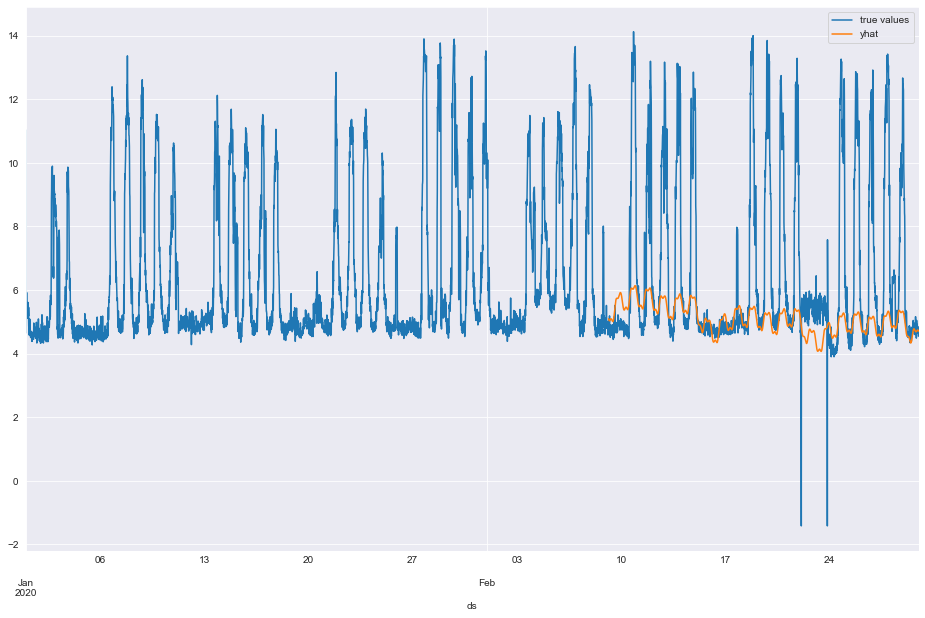

In [47]:
auto_model_bc = Prophet(changepoint_prior_scale=0.5, 
                     seasonality_prior_scale=0.01, 
                     seasonality_mode='multiplicative')
# Fit the model on the training dataset
auto_model_bc.fit(box_cox_train)
# Cross validation
auto_model_bc_cv = cross_validation(auto_model_bc, initial='370 days', period='80 days', horizon = '100 days', parallel="processes")
# Model performance metrics
auto_model_bc_p = performance_metrics(auto_model_bc_cv, rolling_window=1)

print(auto_model_bc_p)
plt.figure(figsize=(16, 10))
df = box_cox_df
#Out of sample forecast
future = box_cox_test[['ds']]
forecast = auto_model_bc.predict(future)[['ds', 'yhat']].set_index('ds')
ax = df[df.index.year == 2020][var].plot(label='true values')
forecast.plot(label='predicted values', ax=ax)
plt.legend()

### TBATS model


The TBATS algorithm decomposes a time series into several components, including the trend component, multiple seasonal components (with different frequencies and phases), and the stochastic component. It then applies a Box-Cox transformation to the data to ensure the stability of the variance and allows for non-linear transformations of the data. The trigonometric seasonality component uses a Fourier series to model the periodic patterns in the data, which can capture both harmonic and non-harmonic seasonalities. Finally, the algorithm models the stochastic component using an ARMA (autoregressive moving average) model with errors that are assumed to be normally distributed.

In [48]:
from tbats import TBATS, BATS
# Fit the model
estimator = TBATS(seasonal_periods=(4,96, 96*7),use_box_cox=False)
model = estimator.fit(df_train)
# Forecast 365 days ahead
y_forecast = model.forecast(steps=400)

In [56]:
y_forecast=model.forecast(steps=2000)

In [57]:

results_tbats_df = pd.DataFrame(df_test)
results_tbats_df['forecast'] = y_forecast

In [55]:
df_test.shape

(2000,)

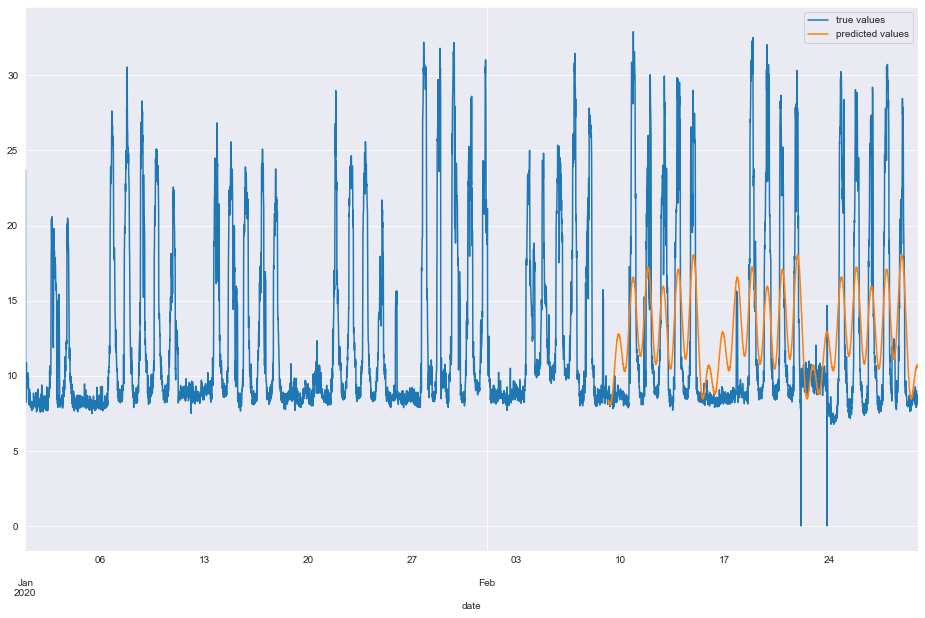

In [58]:
plt.figure(figsize=(16, 10))
df = energy_use
#Out of sample forecast
ax = df[df.index.year == 2020][var].plot(label='true values')
results_tbats_df['forecast'].plot(label='predicted values', ax=ax)
plt.legend()

In [60]:
metrics2(y_forecast, df_test)

TEST SET METRICS
mae: 3.9595130912061083
mape: 1.7033274721694323
rmse: 5.114765136887115


## 3. Models on grouped variable 

Since fitting the model on the full variable did not work well, we are going to compare the behaviour of the same models, except this time we are fitting them on the grouped variable.

In [6]:
# Importamos csv
energy_use['hour'] = energy_use.index.to_period("h")

energy_grouped = energy_use.groupby('hour').mean()
energy_grouped.index = energy_grouped.index.to_timestamp()

The first variable we will study is 'mels_S' (miscellaneous energy use in the south wing of the building).

In [7]:
var = 'mels_S'

Text(0.5, 1.0, 'Energía utilizada en el ala sur')

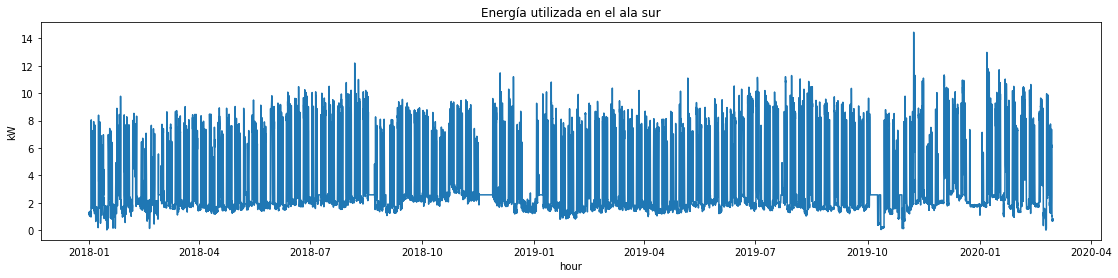

In [8]:
plt.figure(figsize=(19,4))
sns.lineplot(x =energy_grouped.index , y=energy_grouped[var])
plt.ylabel('kW')

plt.title('Energía utilizada en el ala sur')

Text(0.5, 1.0, 'Energía utilizada en el ala sur')

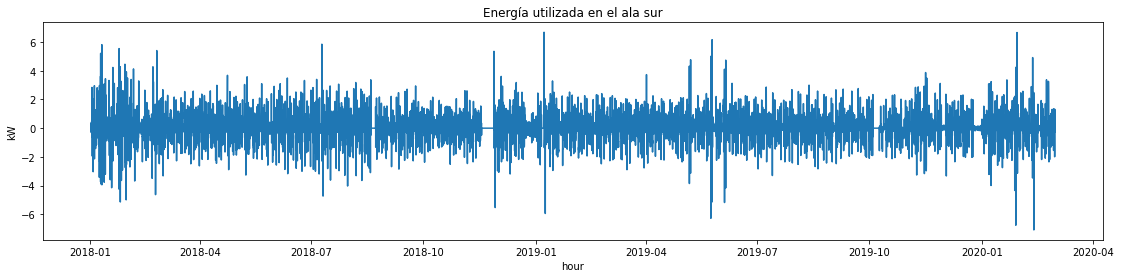

In [14]:
diff = energy_grouped[var]-energy_grouped[var].shift(1)
diff = (diff-diff.shift(24)).dropna()
plt.figure(figsize=(19,4))
sns.lineplot(x =diff.index , y=diff)
plt.ylabel('kW')

plt.title('Energía utilizada en el ala sur')




### ARIMA 

We will fit a very basic ARIMA model into this variable, and we will study its behaviour. Since we have seasonality in our data, we will also use SARIMA and compare the results of fitting both models.
For this model, we have to decide the value of the main parameters:
- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

Also, the frequency we will consider is 672 samples, which is the same as one week.


In [15]:
#Split into train and test: 2020 will be our test set

df_train_grouped = diff[diff.index.year<2020]
df_test_grouped = diff[diff.index.year==2020]

In [16]:
df_train_grouped.shape

(17494,)

In [17]:
df_test_grouped.shape

(1440,)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
arima_full = ARIMA(df_train_grouped, order =(8,0,18))
arima_full_fit = arima_full.fit()
print(arima_full_fit.summary())


KeyboardInterrupt: 

Next, we will plot the residuals (necessary to check if there are patterns):


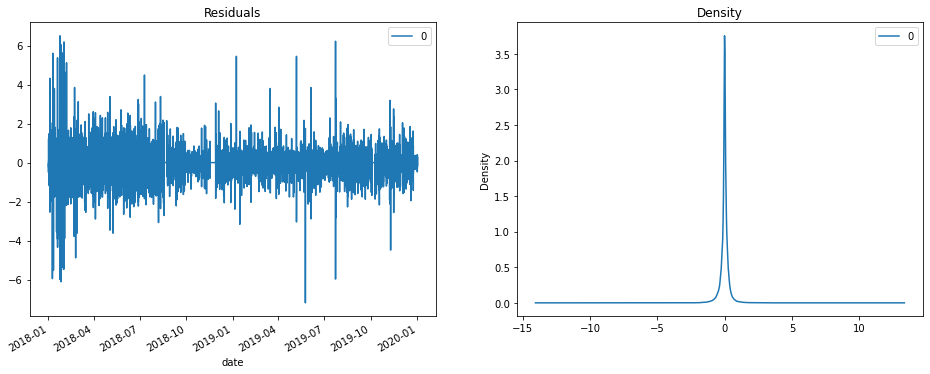

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(arima_full_fit.resid)
fig, ax= plt.subplots(nrows=1,ncols=2, figsize=(16,6) )
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

We want to plot the predictions of the model starting for the test set. We will also check if a dynamic forecasting works better than static one.

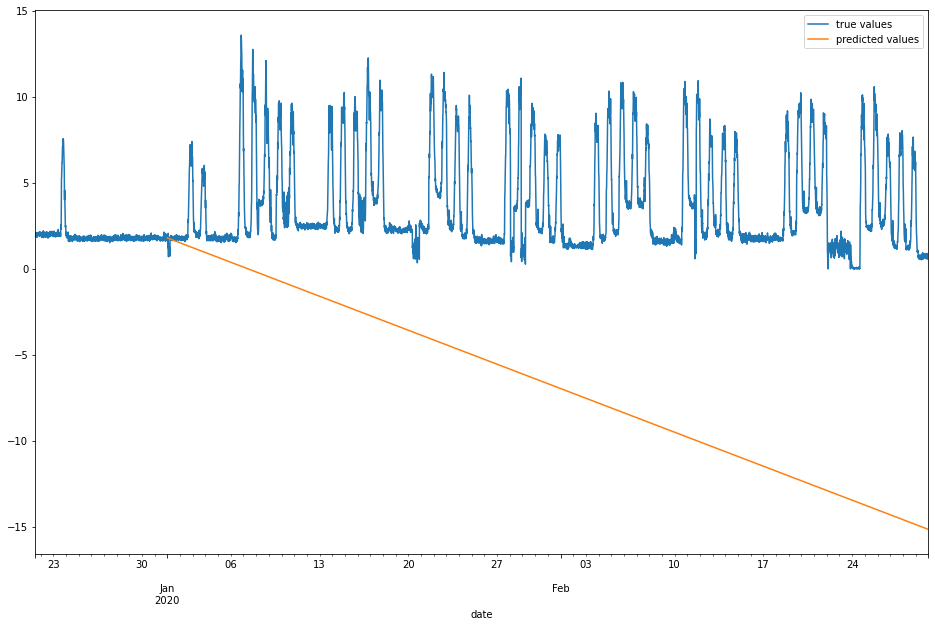

In [ ]:
plot_zoom(arima_full_fit, energy_use, df_test_full, var)

In [ ]:
start = df_train.index[6000]
end = df_train.index[-1]


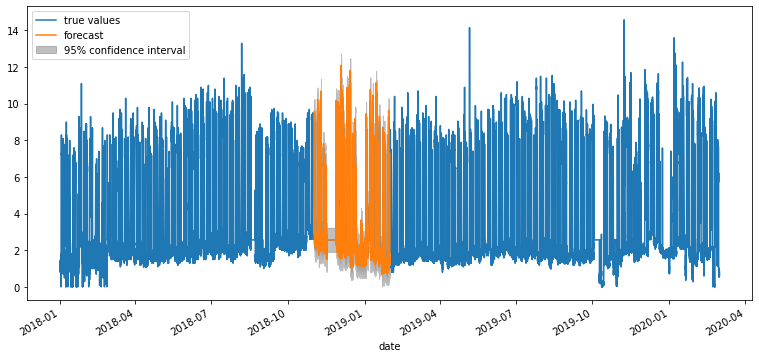

In [ ]:
# Actual vs Fitte
fig, ax = plt.subplots(figsize=(13,6))

ax = energy_use[var].plot(label ='true values', ax=ax)

fig = plot_predict(arima_full_fit, start = start, end = end, ax = ax)
#ax.set_xlim(['2019-01', '2019-02'])
plt.show()

#### Evaluation metrics

We will check the train and test evaluation metrics: MAE (Mean Absolute Error), MAPE (Mean Absolute Percentage Error), and RMSE (Root Mean Squared Error). As we have seen in previous plots, the behaviour in train and test sets is very different:

In [ ]:
metrics(arima_full_fit, df_test_full, df_train_full)

TRAIN SET METRICS
mae: 0.17589185838555338
mape: 0.09073387192824846
rmse: 0.33362804645041994
TEST SET METRICS
mae: 10.364188117044083
mape: 9.65391637069958
rmse: 11.726352447533678


Clearly, we have overfitting, this means that the model is not able to correctly predict outside of the training set.

#### Parameter tuning
Even if we didn't acheive great results with ARIMA, we will try to tune the parameters, comparing models with the AIC and BIC metrics:

In [ ]:
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-2
for p in range(0, 3):

  for d in range(0,3):
  # Loop over q values from 0-2
    for q in range(0, 3):
        print("Model: \np=", p,"\nd=", d, "\nq=", q)
      	# create and fit ARMA(p,q) model
        model = ARIMA(df_train_full, order=(p,d,q))
        results = model.fit()
        
        # Append order and results tuple
        order_aic_bic.append((p, d, q, results.aic, results.bic))

Model: 
p= 0 
d= 0 
q= 0
Model: 
p= 0 
d= 0 
q= 1
Model: 
p= 0 
d= 0 
q= 2
Model: 
p= 0 
d= 1 
q= 0
Model: 
p= 0 
d= 1 
q= 1
Model: 
p= 0 
d= 1 
q= 2
Model: 
p= 0 
d= 2 
q= 0
Model: 
p= 0 
d= 2 
q= 1
Model: 
p= 0 
d= 2 
q= 2
Model: 
p= 1 
d= 0 
q= 0
Model: 
p= 1 
d= 0 
q= 1
Model: 
p= 1 
d= 0 
q= 2
Model: 
p= 1 
d= 1 
q= 0
Model: 
p= 1 
d= 1 
q= 1
Model: 
p= 1 
d= 1 
q= 2
Model: 
p= 1 
d= 2 
q= 0
Model: 
p= 1 
d= 2 
q= 1
Model: 
p= 1 
d= 2 
q= 2
Model: 
p= 2 
d= 0 
q= 0
Model: 
p= 2 
d= 0 
q= 1
Model: 
p= 2 
d= 0 
q= 2
Model: 
p= 2 
d= 1 
q= 0
Model: 
p= 2 
d= 1 
q= 1
Model: 
p= 2 
d= 1 
q= 2
Model: 
p= 2 
d= 2 
q= 0
Model: 
p= 2 
d= 2 
q= 1
Model: 
p= 2 
d= 2 
q= 2


In [ ]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p','d','q','AIC','BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values(by='AIC', ascending=True))



    p  d  q            AIC            BIC
20  2  0  2   41221.400341   41276.473527
19  2  0  1   41577.741782   41623.636104
23  2  1  2   43348.915707   43394.809959
14  1  1  2   43482.705586   43519.420988
22  2  1  1   43521.635679   43558.351080
13  1  1  1   43894.753200   43922.289751
26  2  2  2   45976.381527   46022.275709
25  2  2  1   45990.113990   46026.829336
8   0  2  2   45990.368320   46017.904829
16  1  2  1   45991.863769   46019.400278
17  1  2  2   45992.366310   46029.081655
7   0  2  1   46156.290733   46174.648406
21  2  1  0   46475.526976   46503.063527
11  1  0  2   46706.348004   46752.242326
5   0  1  2   47195.388495   47222.925046
18  2  0  0   47559.764821   47596.480278
10  1  0  1   47825.738292   47862.453749
12  1  1  0   48012.238220   48030.595920
4   0  1  1   48244.722560   48263.080261
9   1  0  0   48734.692805   48762.229398
3   0  1  0   49084.895981   49094.074831
24  2  2  0   56989.610050   57017.146560
15  1  2  0   66744.227850   66762

In [ ]:
print(order_df.sort_values(by='BIC', ascending=True))


    p  d  q            AIC            BIC
20  2  0  2   41221.400341   41276.473527
19  2  0  1   41577.741782   41623.636104
23  2  1  2   43348.915707   43394.809959
14  1  1  2   43482.705586   43519.420988
22  2  1  1   43521.635679   43558.351080
13  1  1  1   43894.753200   43922.289751
8   0  2  2   45990.368320   46017.904829
16  1  2  1   45991.863769   46019.400278
26  2  2  2   45976.381527   46022.275709
25  2  2  1   45990.113990   46026.829336
17  1  2  2   45992.366310   46029.081655
7   0  2  1   46156.290733   46174.648406
21  2  1  0   46475.526976   46503.063527
11  1  0  2   46706.348004   46752.242326
5   0  1  2   47195.388495   47222.925046
18  2  0  0   47559.764821   47596.480278
10  1  0  1   47825.738292   47862.453749
12  1  1  0   48012.238220   48030.595920
4   0  1  1   48244.722560   48263.080261
9   1  0  0   48734.692805   48762.229398
3   0  1  0   49084.895981   49094.074831
24  2  2  0   56989.610050   57017.146560
15  1  2  0   66744.227850   66762

We will repeat previous steps with ARIMA(2,0,2)

                               SARIMAX Results                                
Dep. Variable:                 mels_S   No. Observations:                75361
Model:                 ARIMA(1, 2, 2)   Log Likelihood              -25400.690
Date:                Mon, 28 Nov 2022   AIC                          50809.381
Time:                        19:57:49   BIC                          50846.301
Sample:                             0   HQIC                         50820.729
                              - 75361                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0255      0.024      1.073      0.283      -0.021       0.072
ma.L1         -0.9384      0.024    -39.403      0.000      -0.985      -0.892
ma.L2          0.0727      0.021      3.482      0.0

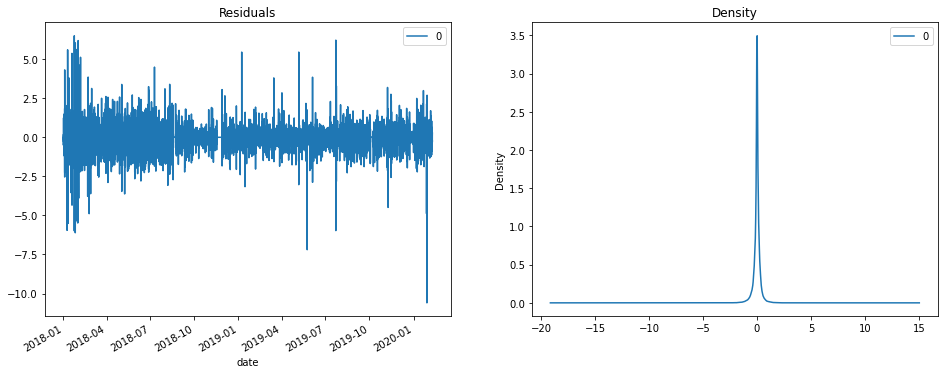

TRAIN SET METRICS
mae: 0.1760256619005799
mape: 0.09076040355951204
rmse: 0.33363016304125265
TEST SET METRICS
mae: 2.186013277100955
mape: 2.4836165460441135
rmse: 3.005730588870054


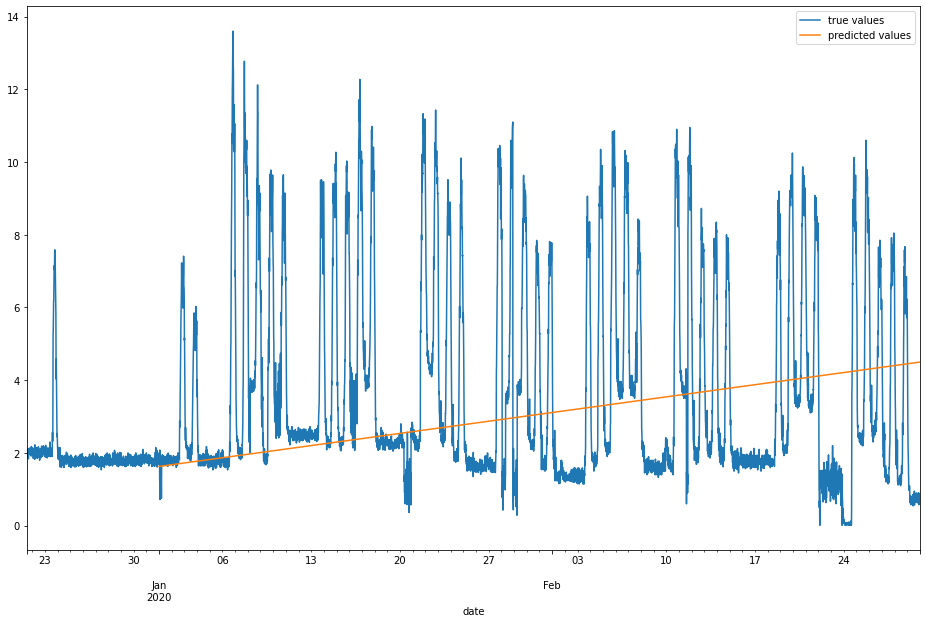

In [ ]:
arima_tuned = ARIMA(df_train_full, order =(2,0,2))
arima_tuned_fit = model.fit()
print(arima_tuned_fit.summary())


# Plot residual errors
residuals = pd.DataFrame(arima_tuned_fit.resid)
fig, ax= plt.subplots(nrows=1,ncols=2, figsize=(16,6) )
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

plot_zoom(arima_tuned_fit, energy_use, df_test_full, var)
metrics(arima_tuned_fit, df_test_full, df_train_full)




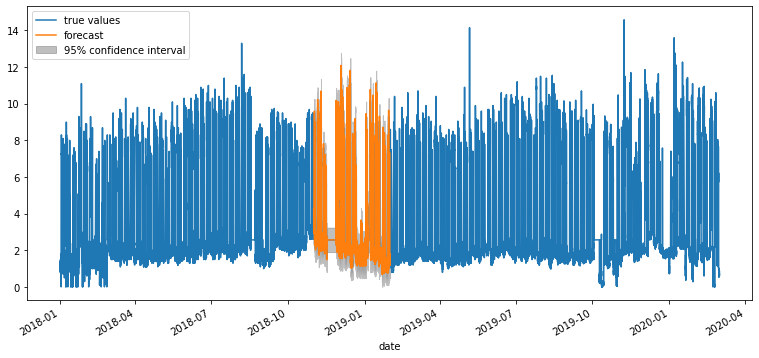

In [ ]:
# Actual vs Fitte
fig, ax = plt.subplots(figsize=(13,6))

ax = energy_use[var].plot(label ='true values', ax=ax)

fig = plot_predict(arima_tuned_fit, start = start, end = end, ax = ax)
#ax.set_xlim(['2019-01', '2019-02'])
plt.show()

### SARIMAX
Even though our variable is stationary, we are going to fit a sarimax model and check the accuracy of its forecasts.

In [ ]:
sarimax_full = sm.tsa.statespace.SARIMAX(energy_use[var],order=(2,0,2),
                                                seasonal_order=(2,0,2,12),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

sarimax_full_fit = sarimax_full.fit(maxiter=50) 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.57319D+00    |proj g|=  2.38759D+01

At iterate    5    f=  1.22452D+00    |proj g|=  3.37440D+00

At iterate   10    f=  5.90425D-01    |proj g|=  8.78811D-01

At iterate   15    f=  3.50082D-01    |proj g|=  3.38516D-01

At iterate   20    f=  3.26155D-01    |proj g|=  1.05723D-01

At iterate   25    f=  3.24021D-01    |proj g|=  5.43934D-02

At iterate   30    f=  3.21883D-01    |proj g|=  8.58242D-02

At iterate   35    f=  3.21730D-01    |proj g|=  4.62955D-01

At iterate   40    f=  3.20790D-01    |proj g|=  1.52688D-01

At iterate   45    f=  3.20515D-01    |proj g|=  4.38319D-02

At iterate   50    f=  3.20507D-01    |proj g|=  2.87821D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

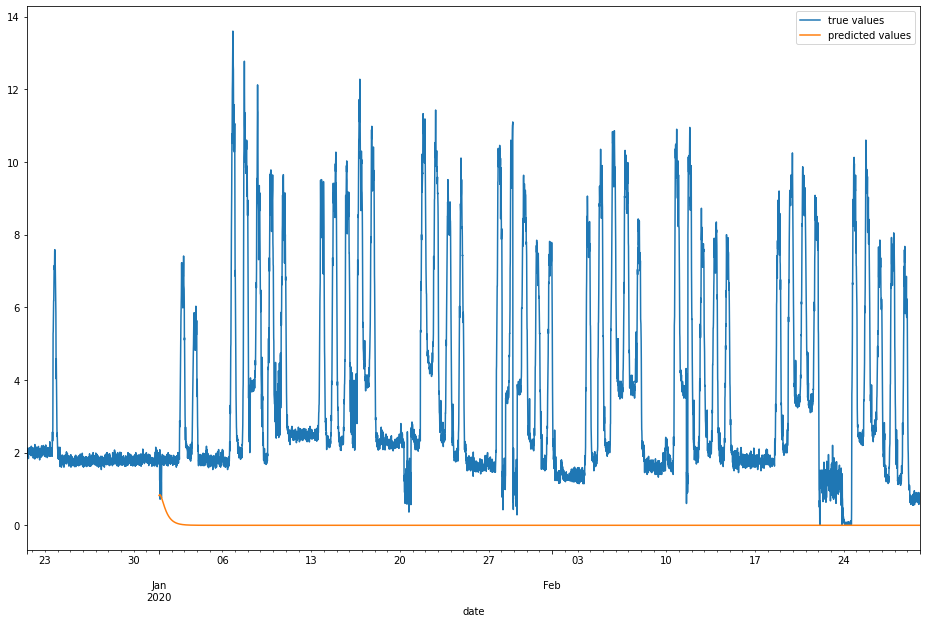

In [ ]:
plot_zoom(sarimax_fit, energy_use, df_test_full, var)

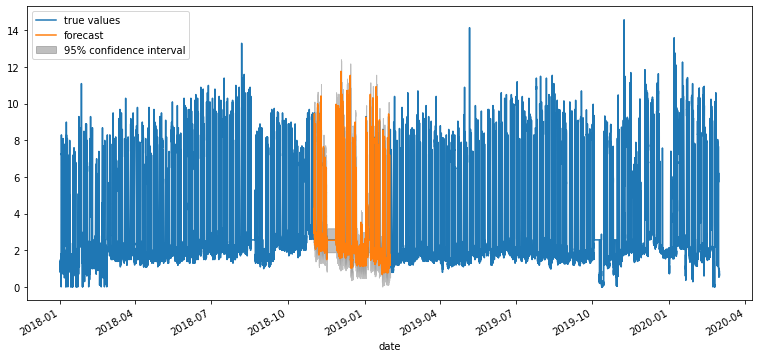

In [ ]:

# Actual vs Fitte
fig, ax = plt.subplots(figsize=(13,6))

ax = energy_use[var].plot(label ='true values', ax=ax)

fig = plot_predict(sarimax_fit, start = start, end = end, ax = ax)
#ax.set_xlim(['2019-01', '2019-02'])
plt.legend()
plt.show()

Next, we will compare the MSE of both models:

In [ ]:
metrics(sarimax_fit, df_test, df_train)

TRAIN SET METRICS
mae: 0.10912136778463861
mape: 0.03278537966949469
rmse: 0.20691686012463906
TEST SET METRICS
mae: 3.156950959954527
mape: 0.9912578358260837
rmse: 3.9959285011301193
